Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  12
the actual len of the pred vect is :  12
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.0
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors               

c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  82
the actual len of the pred vect is :  82
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0]
[1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  93
the actual len of the pred vect is :  93
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint

the actual len of the gt vect is :  181
the actual len of the pred vect is :  181
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  186
the actual len of the pred vect is :  186
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0]
[0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8


c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  195
the actual len of the pred vect is :  195
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0]
[1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  199
the actual len of the pred vect is :  199
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0]
[0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape

c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  228
the actual len of the pred vect is :  228
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  236
the actual len of the pred vect is :  236
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8


the actual len of the gt vect is :  333
the actual len of the pred vect is :  333
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  337
the actual len of the pred vect is :  337
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0]
[0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images           

the actual len of the gt vect is :  435
the actual len of the pred vect is :  435
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  448
the actual len of the pred vect is :  448
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Processing 1 images
image                 

the actual len of the gt vect is :  539
the actual len of the pred vect is :  539
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  545
the actual len of the pred vect is :  545
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8


c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  548
the actual len of the pred vect is :  548
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0]
[1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  552
the actual len of the pred vect is :  552
Average precision of this image :  0.5
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0]
[1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 

c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  588
the actual len of the pred vect is :  588
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  597
the actual len of the pred vect is :  597
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  

the actual len of the gt vect is :  649
the actual len of the pred vect is :  649
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0]
[0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  652
the actual len of the pred vect is :  652
Average precision of this image :  0.3333333333333333
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0]
[1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  694
the actual len of the pred vect is :  694
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[2, 2, 0]
[0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max

the actual len of the gt vect is :  733
the actual len of the pred vect is :  733
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0]
[0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  739
the actual len of the pred vect is :  739
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  775
the actual len of the pred vect is :  775
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0]
[0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.3539

the actual len of the gt vect is :  818
the actual len of the pred vect is :  818
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0]
[0, 0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  823
the actual len of the pred vect is :  823
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0, 0]
[0, 0, 0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images           

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  860
the actual len of the pred vect is :  860
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0]
[0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max

the actual len of the gt vect is :  904
the actual len of the pred vect is :  904
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[2, 2, 0]
[0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  907
the actual len of the pred vect is :  907
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0]
[0, 0, 0]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  956
the actual len of the pred vect is :  956
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 1, 0]
[0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max

the actual len of the gt vect is :  1005
the actual len of the pred vect is :  1005
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0]
[0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1008
the actual len of the pred vect is :  1008
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[2, 2, 0]
[0, 0, 0]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 10

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1061
the actual len of the pred vect is :  1061
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:  

c:\users\sedra\venv\lib\site-packages\mask_rcnn-2.1-py3.6.egg\mrcnn\utils.py:741: RuntimeWarning: invalid value encountered in true_divide


the actual len of the gt vect is :  1115
the actual len of the pred vect is :  1115
Average precision of this image :  nan
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0]
[1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1119
the actual len of the pred vect is :  1119
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 0, 0]
[0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: 

the actual len of the gt vect is :  1175
the actual len of the pred vect is :  1175
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1180
the actual len of the pred vect is :  1180
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0, 0]
[0, 0, 0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images 

the actual len of the gt vect is :  1245
the actual len of the pred vect is :  1245
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0]
[0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1248
the actual len of the pred vect is :  1248
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[2, 0, 0]
[0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: 

the actual len of the gt vect is :  1323
the actual len of the pred vect is :  1323
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 2, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1330
the actual len of the pred vect is :  1330
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 1, 2, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  ui

the actual len of the gt vect is :  1393
the actual len of the pred vect is :  1393
Average precision of this image :  0.125
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0, 0]
[1, 0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  122.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1398
the actual len of the pred vect is :  1398
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 1, 1, 1, 0]
[0, 0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_image

the actual len of the gt vect is :  1461
the actual len of the pred vect is :  1461
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0, 0]
[0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  123.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1471
the actual len of the pred vect is :  1471
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 1, 1, 1, 1, 1, 2, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  2

the actual len of the gt vect is :  1535
the actual len of the pred vect is :  1535
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 0, 0, 0, 0]
[0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  124.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1539
the actual len of the pred vect is :  1539
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0]
[0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  245.00000  uint8
molded_images       

the actual len of the gt vect is :  1600
the actual len of the pred vect is :  1600
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 1, 0, 0, 0]
[0, 0, 0, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1606
the actual len of the pred vect is :  1606
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_i

the actual len of the gt vect is :  1666
the actual len of the pred vect is :  1666
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[1, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  122.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1672
the actual len of the pred vect is :  1672
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  nan
[0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
mo

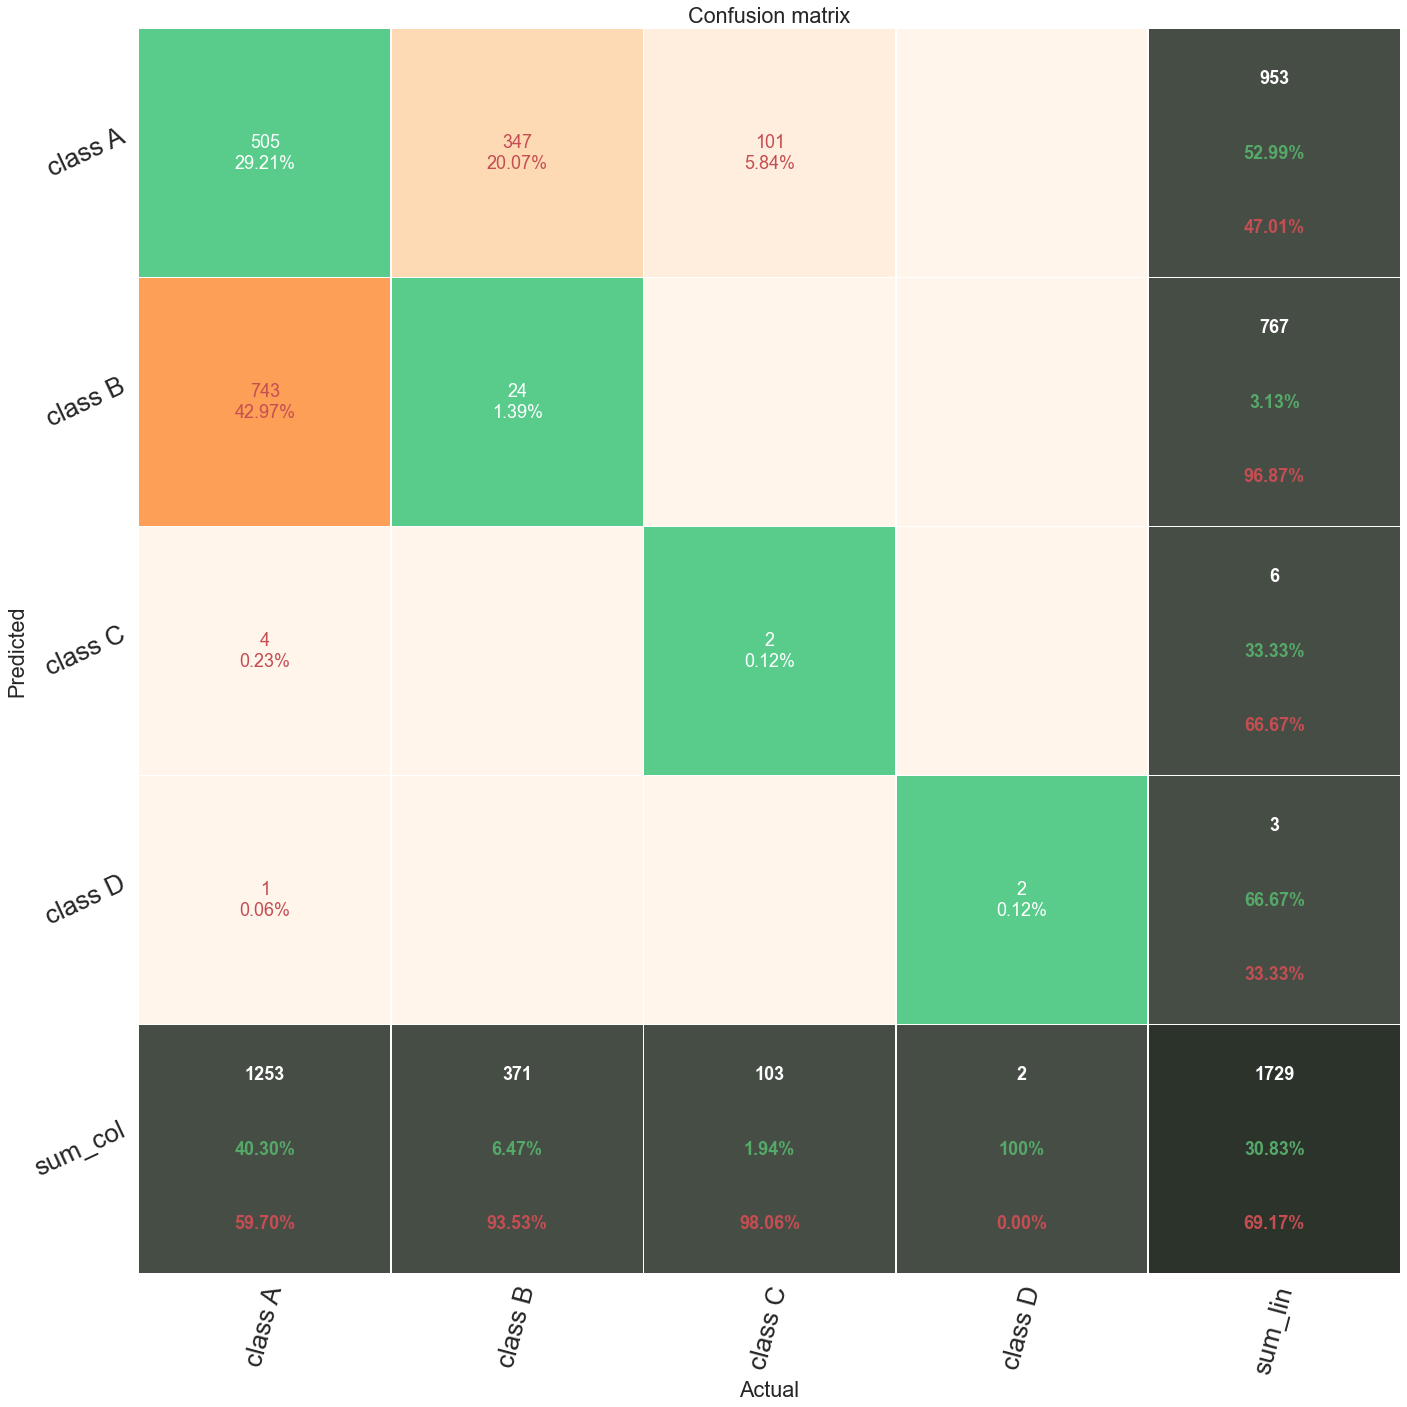

In [4]:
'''
Creates a confusion matrix from a set of images and a pre-loaded weight
Modified from: https://github.com/Altimis/Confusion-matrix-for-Mask-R-CNN
'''

# an example of plotting confusion matrix.
# the first step consists of computing ground-truth and prediction vectors for all images.
# using these vectors, the plot_confusion_matrix_from_data function plots the CM and computes tps fps and fns
from mrcnn import utils
import mrcnn.model
from mrcnn.config import Config
import pandas as pd
import numpy as np
import os 
from normalize_classnames import normalize_classname
import cv2
from model.dataset import Model_Dataset

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

CLASSES = ['lack of fusion porosity', 'keyhole porosity', 'other']

class InferenceConfig(Config):
    NAME = 'inference'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 3 + 1
    
# configure model and make predictions
       
config = InferenceConfig()
dataset = ModelDataset()
dataset.BASE_IMAGES_DIR = '../../Data/Images/'
dataset.BASE_ANNOTATIONS_DIR = '../../Data/Labels/'
dataset.IMAGES_DIRS = ['H6']
dataset.load_dataset()
dataset.prepare()

model = MaskRCNN(mode='inference',
                 config=InferenceConfig(), model_dir='./')
model.load_weights(filepath='../custom_mrcnn.h5', by_name=True)

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        mrcnn.model.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))
    print(gt)
    print(pred)
#     print("Ground truth object : "+dataset.class_names[gt])
#     print("Predicted object : "+dataset.class_names[pred])
 

gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
    
#print the confusion matrix and compute true postives, false positives and false negative for each class: 
#ps : you can controle the figure size and text format by choosing the right values
#tp, fp, fn = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)

###########################################################################################################################

#since in this notebook i didnt run the loop above, here is an example of plotting using manual generated vectors :
#let 0 be the background class
#gt_tot=[1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,1,2,3,0,1,2,3,0,1,2,0]
#pred_tot=[1,2,3,3,2,1,1,2,3,1,2,3,1,2,0,2,2,2,3,1,0,0,3,2,1,2,0]

#supose we have 1 image containing the gt classes bellow :
gt_class_id = np.array([1,2,3,1,2,3])
#with the bbox :
gt_bbox = np.array([np.array([10,100,20,200]),np.array([100,10,200,20]),np.array([110,15,220,25]),np.array([20,200,20,200]),
                    np.array([90,15,220,20]),np.array([100,10,150,20])])
#and the model detected the classes : 
pred_class_id = np.array([2,3,2,3,2,3])
#with the bbox : 
pred_bbox = np.array([np.array([100,10,200,20]),np.array([110,15,220,25]),np.array([90,15,220,20]),np.array([101,20,100,21]),
                    np.array([500,20,1,20]),np.array([100,10,150,20])])

#for this image, the gt and pred lists are :    
gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, pred_class_id, pred_bbox)
gt_tot = np.append(gt_tot, gt)
pred_tot = np.append(pred_tot, pred)

print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)

#here i didnt set the columns list, since in the code if columns is note specified 
#it generates automatically a list from "class A" to "class ..". in this example, class A should be the background
#Note : class A is the backround in this example
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(20,20), lw=0.5)

In [ ]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class (class A) from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)